## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools
import tensorflow as tf
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
                
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-6, 1e-8, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-6, 1e-8, 0.0]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1, l2 in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 Regulizer = %.8f L2 Regulizer = %.8f" % (l1, l2))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1, l2_ratio=l2)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1), str(l2))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 Regulizer = 0.01000000 L2 Regulizer = 0.01000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 sampl

50000/50000 [==============================] - 4s 74us/step - loss: 2.4614 - accuracy: 0.0986 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 4s 74us/step - loss: 2.4614 - accuracy: 0.0973 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 4s 73us/step - loss: 2.4614 - accuracy: 0.0984 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with L1 Regulizer = 0.01000000 L2 Regulizer = 0.00010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________

Epoch 46/50
50000/50000 [==============================] - 7s 141us/step - loss: 2.4626 - accuracy: 0.0980 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 7s 142us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.4626 - accuracy: 0.0988 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.4626 - accuracy: 0.0961 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4627 - val_accuracy: 0.1000
Experiment with L1 Regulizer = 0.01000000 L2 Regulizer = 0.00000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30

50000/50000 [==============================] - 6s 115us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 6s 123us/step - loss: 2.4626 - accuracy: 0.0965 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 5s 98us/step - loss: 2.4626 - accuracy: 0.0989 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 5s 92us/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 5s 94us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4626 - accuracy: 0.0969 - val_loss: 2.

50000/50000 [==============================] - 6s 118us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.4626 - accuracy: 0.0975 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 6s 118us/step - loss: 2.4626 - accuracy: 0.0992 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.4626 - accuracy: 0.0999 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.4626 - accuracy: 0.0977 - val_loss:

50000/50000 [==============================] - 4s 81us/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 38/50
50000/50000 [==============================] - 4s 83us/step - loss: 2.4626 - accuracy: 0.0997 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 4s 85us/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 4s 90us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 5s 95us/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.46

50000/50000 [==============================] - 9s 182us/step - loss: 1.8412 - accuracy: 0.4618 - val_loss: 1.8589 - val_accuracy: 0.4482
Epoch 35/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.8334 - accuracy: 0.4621 - val_loss: 1.8421 - val_accuracy: 0.4592
Epoch 36/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.8238 - accuracy: 0.4630 - val_loss: 1.8341 - val_accuracy: 0.4587- accuracy
Epoch 37/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.8176 - accuracy: 0.4638 - val_loss: 1.8240 - val_accuracy: 0.4565
Epoch 38/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.8067 - accuracy: 0.4658 - val_loss: 1.8343 - val_accuracy: 0.4508
Epoch 39/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.8028 - accuracy: 0.4678 - val_loss: 1.8236 - val_accuracy: 0.4563
Epoch 40/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.7958 - accuracy: 0.4676 - val_

50000/50000 [==============================] - 5s 92us/step - loss: 3.4982 - accuracy: 0.5800 - val_loss: 3.6617 - val_accuracy: 0.5210
Epoch 32/50
50000/50000 [==============================] - 5s 91us/step - loss: 3.4444 - accuracy: 0.5836 - val_loss: 3.5794 - val_accuracy: 0.5255
Epoch 33/50
50000/50000 [==============================] - 6s 112us/step - loss: 3.3915 - accuracy: 0.5872 - val_loss: 3.5705 - val_accuracy: 0.5198
Epoch 34/50
50000/50000 [==============================] - 5s 98us/step - loss: 3.3329 - accuracy: 0.5912 - val_loss: 3.5055 - val_accuracy: 0.5149
Epoch 35/50
50000/50000 [==============================] - 5s 97us/step - loss: 3.2829 - accuracy: 0.5917 - val_loss: 3.4724 - val_accuracy: 0.5235
Epoch 36/50
50000/50000 [==============================] - 5s 103us/step - loss: 3.2287 - accuracy: 0.5969 - val_loss: 3.4296 - val_accuracy: 0.5182
Epoch 37/50
50000/50000 [==============================] - 5s 95us/step - loss: 3.1782 - accuracy: 0.6000 - val_loss: 3.33

50000/50000 [==============================] - 8s 169us/step - loss: 3.6521 - accuracy: 0.5746 - val_loss: 3.7799 - val_accuracy: 0.5209
Epoch 29/50
50000/50000 [==============================] - 8s 169us/step - loss: 3.5971 - accuracy: 0.5789 - val_loss: 3.7103 - val_accuracy: 0.5282
Epoch 30/50
50000/50000 [==============================] - 8s 169us/step - loss: 3.5433 - accuracy: 0.5826 - val_loss: 3.7225 - val_accuracy: 0.5135
Epoch 31/50
50000/50000 [==============================] - 8s 169us/step - loss: 3.4877 - accuracy: 0.5846 - val_loss: 3.6242 - val_accuracy: 0.5298
Epoch 32/50
50000/50000 [==============================] - 8s 169us/step - loss: 3.4299 - accuracy: 0.5886 - val_loss: 3.6615 - val_accuracy: 0.5068
Epoch 33/50
50000/50000 [==============================] - 8s 169us/step - loss: 3.3810 - accuracy: 0.5910 - val_loss: 3.6491 - val_accuracy: 0.4931
Epoch 34/50
50000/50000 [==============================] - 9s 172us/step - loss: 3.3321 - accuracy: 0.5923 - val_loss:

50000/50000 [==============================] - 9s 171us/step - loss: 3.8254 - accuracy: 0.5660 - val_loss: 3.9330 - val_accuracy: 0.5111
Epoch 26/50
50000/50000 [==============================] - 9s 170us/step - loss: 3.7671 - accuracy: 0.5712 - val_loss: 3.8822 - val_accuracy: 0.5164
Epoch 27/50
50000/50000 [==============================] - 9s 171us/step - loss: 3.7091 - accuracy: 0.5716 - val_loss: 3.8428 - val_accuracy: 0.5139
Epoch 28/50
50000/50000 [==============================] - 9s 171us/step - loss: 3.6519 - accuracy: 0.5751 - val_loss: 3.8078 - val_accuracy: 0.5093
Epoch 29/50
50000/50000 [==============================] - 9s 171us/step - loss: 3.5946 - accuracy: 0.5812 - val_loss: 3.8311 - val_accuracy: 0.4948
Epoch 30/50
50000/50000 [==============================] - 9s 170us/step - loss: 3.5393 - accuracy: 0.5814 - val_loss: 3.7762 - val_accuracy: 0.4917
Epoch 31/50
50000/50000 [==============================] - 9s 171us/step - loss: 3.4830 - accuracy: 0.5875 - val_loss:

50000/50000 [==============================] - 9s 178us/step - loss: 4.0088 - accuracy: 0.5554 - val_loss: 4.1015 - val_accuracy: 0.5144
Epoch 23/50
50000/50000 [==============================] - 8s 168us/step - loss: 3.9484 - accuracy: 0.5597 - val_loss: 4.0401 - val_accuracy: 0.5046
Epoch 24/50
50000/50000 [==============================] - 8s 166us/step - loss: 3.8865 - accuracy: 0.5628 - val_loss: 3.9776 - val_accuracy: 0.5140
Epoch 25/50
50000/50000 [==============================] - 8s 165us/step - loss: 3.8224 - accuracy: 0.5671 - val_loss: 3.9254 - val_accuracy: 0.5217
Epoch 26/50
50000/50000 [==============================] - 8s 168us/step - loss: 3.7657 - accuracy: 0.5717 - val_loss: 3.8961 - val_accuracy: 0.5092
Epoch 27/50
50000/50000 [==============================] - 9s 173us/step - loss: 3.7047 - accuracy: 0.5756 - val_loss: 3.8333 - val_accuracy: 0.5167
Epoch 28/50
50000/50000 [==============================] - 8s 166us/step - loss: 3.6477 - accuracy: 0.5769 - val_loss:

50000/50000 [==============================] - 8s 169us/step - loss: 2.4833 - accuracy: 0.4683 - val_loss: 2.4417 - val_accuracy: 0.4606
Epoch 20/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.3656 - accuracy: 0.4699 - val_loss: 2.3285 - val_accuracy: 0.4622
Epoch 21/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.2674 - accuracy: 0.4718 - val_loss: 2.2529 - val_accuracy: 0.4575
Epoch 22/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.1813 - accuracy: 0.4740 - val_loss: 2.1701 - val_accuracy: 0.4674
Epoch 23/50
50000/50000 [==============================] - 9s 174us/step - loss: 2.1086 - accuracy: 0.4762 - val_loss: 2.1166 - val_accuracy: 0.4585
Epoch 24/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.0452 - accuracy: 0.4778 - val_loss: 2.0334 - val_accuracy: 0.4697
Epoch 25/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.9887 - accuracy: 0.4833 - val_loss:

50000/50000 [==============================] - 9s 171us/step - loss: 1.5149 - accuracy: 0.5306 - val_loss: 1.5880 - val_accuracy: 0.4987
Epoch 17/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.4959 - accuracy: 0.5351 - val_loss: 1.5921 - val_accuracy: 0.4974
Epoch 18/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.4783 - accuracy: 0.5431 - val_loss: 1.5789 - val_accuracy: 0.5070
Epoch 19/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.4625 - accuracy: 0.5490 - val_loss: 1.5742 - val_accuracy: 0.5075
Epoch 20/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.4472 - accuracy: 0.5548 - val_loss: 1.5606 - val_accuracy: 0.5120
Epoch 21/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.4320 - accuracy: 0.5591 - val_loss: 1.5409 - val_accuracy: 0.5164
Epoch 22/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.4157 - accuracy: 0.5660 - val_loss:

50000/50000 [==============================] - 9s 171us/step - loss: 1.4155 - accuracy: 0.5169 - val_loss: 1.4810 - val_accuracy: 0.4859
Epoch 14/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.3961 - accuracy: 0.5235 - val_loss: 1.4530 - val_accuracy: 0.4948
Epoch 15/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.3768 - accuracy: 0.5296 - val_loss: 1.4746 - val_accuracy: 0.4895
Epoch 16/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.3592 - accuracy: 0.5350 - val_loss: 1.4617 - val_accuracy: 0.4995
Epoch 17/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.3419 - accuracy: 0.5417 - val_loss: 1.4386 - val_accuracy: 0.5007
Epoch 18/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.3225 - accuracy: 0.5487 - val_loss: 1.4255 - val_accuracy: 0.5075
Epoch 19/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.3075 - accuracy: 0.5555 - val_loss:

50000/50000 [==============================] - 9s 171us/step - loss: 1.5020 - accuracy: 0.4851 - val_loss: 1.5244 - val_accuracy: 0.4747
Epoch 11/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.4787 - accuracy: 0.4951 - val_loss: 1.5116 - val_accuracy: 0.4773
Epoch 12/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.4542 - accuracy: 0.5050 - val_loss: 1.4964 - val_accuracy: 0.4819
Epoch 13/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.4340 - accuracy: 0.5102 - val_loss: 1.5001 - val_accuracy: 0.4883
Epoch 14/50
50000/50000 [==============================] - 8s 170us/step - loss: 1.4130 - accuracy: 0.5171 - val_loss: 1.4894 - val_accuracy: 0.4819
Epoch 15/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.3925 - accuracy: 0.5259 - val_loss: 1.4541 - val_accuracy: 0.4972
Epoch 16/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.3740 - accuracy: 0.5306 - val_loss:

50000/50000 [==============================] - 8s 162us/step - loss: 1.5803 - accuracy: 0.4594 - val_loss: 1.5858 - val_accuracy: 0.4590
Epoch 8/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.5492 - accuracy: 0.4697 - val_loss: 1.5619 - val_accuracy: 0.4650
Epoch 9/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.5214 - accuracy: 0.4804 - val_loss: 1.5494 - val_accuracy: 0.4683
Epoch 10/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.4957 - accuracy: 0.4875 - val_loss: 1.5329 - val_accuracy: 0.4752
Epoch 11/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4721 - accuracy: 0.4974 - val_loss: 1.5094 - val_accuracy: 0.4819
Epoch 12/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.4497 - accuracy: 0.5063 - val_loss: 1.4927 - val_accuracy: 0.4837
Epoch 13/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.4299 - accuracy: 0.5116 - val_loss: 1

50000/50000 [==============================] - 9s 171us/step - loss: 9.9263 - accuracy: 0.3989 - val_loss: 9.2966 - val_accuracy: 0.4008
Epoch 5/50
50000/50000 [==============================] - 9s 171us/step - loss: 8.7269 - accuracy: 0.4078 - val_loss: 8.1814 - val_accuracy: 0.4149
Epoch 6/50
50000/50000 [==============================] - 9s 172us/step - loss: 7.7049 - accuracy: 0.4166 - val_loss: 7.2409 - val_accuracy: 0.4208
Epoch 7/50
50000/50000 [==============================] - 9s 170us/step - loss: 6.8341 - accuracy: 0.4220 - val_loss: 6.4413 - val_accuracy: 0.4244
Epoch 8/50
50000/50000 [==============================] - 8s 170us/step - loss: 6.0921 - accuracy: 0.4263 - val_loss: 5.7602 - val_accuracy: 0.4324
Epoch 9/50
50000/50000 [==============================] - 8s 170us/step - loss: 5.4569 - accuracy: 0.4342 - val_loss: 5.1880 - val_accuracy: 0.4248
Epoch 10/50
50000/50000 [==============================] - 9s 171us/step - loss: 4.9154 - accuracy: 0.4370 - val_loss: 4.66

50000/50000 [==============================] - 6s 129us/step - loss: 2.1735 - accuracy: 0.2753 - val_loss: 2.0093 - val_accuracy: 0.3400
Epoch 2/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.9533 - accuracy: 0.3635 - val_loss: 1.9051 - val_accuracy: 0.3835
Epoch 3/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.8689 - accuracy: 0.3919 - val_loss: 1.8366 - val_accuracy: 0.4029
Epoch 4/50
50000/50000 [==============================] - 11s 223us/step - loss: 1.8105 - accuracy: 0.4132 - val_loss: 1.7819 - val_accuracy: 0.4251
Epoch 5/50
50000/50000 [==============================] - 39s 779us/step - loss: 1.7638 - accuracy: 0.4302 - val_loss: 1.7473 - val_accuracy: 0.4411
Epoch 6/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.7241 - accuracy: 0.4433 - val_loss: 1.7149 - val_accuracy: 0.4444
Epoch 7/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.6904 - accuracy: 0.4572 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 113us/step - loss: 2.0171 - accuracy: 0.2914 - val_loss: 1.8526 - val_accuracy: 0.3537
Epoch 2/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.8029 - accuracy: 0.3684 - val_loss: 1.7601 - val_accuracy: 0.3783
Epoch 3/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.7213 - accuracy: 0.3975 - val_loss: 1.6926 - val_accuracy: 0.4064
Epoch 4/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.6632 - accuracy: 0.4156 - val_loss: 1.6472 - val_accuracy: 0.4237
Epoch 5/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.6164 - accuracy: 0.4346 - val_loss: 1.5997 - val_accuracy: 0.4360
Epoch 6/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.5772 - accuracy: 0.4485 - val_loss: 1.5755 - val_accuracy: 0.4477
Epoch 7/50
50000/50000 [==============================] - 5s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.9935 - accuracy: 0.2887 - val_loss: 1.8423 - val_accuracy: 0.3439
Epoch 2/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.7840 - accuracy: 0.3731 - val_loss: 1.7388 - val_accuracy: 0.3820
Epoch 3/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.7026 - accuracy: 0.4021 - val_loss: 1.6649 - val_accuracy: 0.4168
Epoch 4/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.6479 - accuracy: 0.4192 - val_loss: 1.6247 - val_accuracy: 0.4308
Epoch 5/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.6025 - accuracy: 0.4368 - val_loss: 1.5872 - val_accuracy: 0.4407
Epoch 6/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.5660 - accuracy: 0.4504 - val_loss: 1.5632 - val_accuracy: 0.4500
Epoch 7/50
50000/50000 [==============================] - 4s 81u

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 125us/step - loss: 2.0353 - accuracy: 0.2715 - val_loss: 1.8640 - val_accuracy: 0.3403
Epoch 2/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.8098 - accuracy: 0.3628 - val_loss: 1.7622 - val_accuracy: 0.3820
Epoch 3/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.7308 - accuracy: 0.3945 - val_loss: 1.7143 - val_accuracy: 0.3951
Epoch 4/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.6741 - accuracy: 0.4131 - val_loss: 1.6561 - val_accuracy: 0.4221
Epoch 5/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.6271 - accuracy: 0.4306 - val_loss: 1.6158 - val_accuracy: 0.4330
Epoch 6/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.5883 - accuracy: 0.4447 - val_loss: 1.5835 - val_accuracy: 0.4492
Epoch 7/50
50000/50000 [==============================] - 4s 80us/

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 146us/step - loss: 15.0556 - accuracy: 0.2812 - val_loss: 13.9123 - val_accuracy: 0.3420
Epoch 2/50
50000/50000 [==============================] - 7s 147us/step - loss: 12.9810 - accuracy: 0.3621 - val_loss: 12.0859 - val_accuracy: 0.3755
Epoch 3/50
50000/50000 [==============================] - 5s 103us/step - loss: 11.3106 - accuracy: 0.3872 - val_loss: 10.5582 - val_accuracy: 0.3963
Epoch 4/50
50000/50000 [==============================] - 4s 90us/step - loss: 9.9024 - accuracy: 0.4010 - val_loss: 9.2671 - val_accuracy: 0.4022
Epoch 5/50
50000/50000 [==============================] - 4s 89us/step - loss: 8.7071 - accuracy: 0.4100 - val_loss: 8.1768 - val_accuracy: 0.4101
Epoch 6/50
50000/50000 [==============================] - 5s 102us/step - loss: 7.6873 - accuracy: 0.4171 - val_loss: 7.2382 - val_accuracy: 0.4151
Epoch 7/50
50000/50000 [==============================] - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.1607 - accuracy: 0.2796 - val_loss: 1.9908 - val_accuracy: 0.3477
Epoch 2/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.9311 - accuracy: 0.3719 - val_loss: 1.8755 - val_accuracy: 0.3894
Epoch 3/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.8477 - accuracy: 0.4022 - val_loss: 1.8180 - val_accuracy: 0.4041
Epoch 4/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.7932 - accuracy: 0.4191 - val_loss: 1.7669 - val_accuracy: 0.4280
Epoch 5/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.7481 - accuracy: 0.4367 - val_loss: 1.7361 - val_accuracy: 0.4336
Epoch 6/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.7086 - accuracy: 0.4483 - val_loss: 1.7071 - val_accuracy: 0.4513
Epoch 7/50
50000/50000 [==============================] - 4s 78us

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 80us/step - loss: 2.0452 - accuracy: 0.2727 - val_loss: 1.8708 - val_accuracy: 0.3402
Epoch 2/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.8057 - accuracy: 0.3642 - val_loss: 1.7599 - val_accuracy: 0.3808
Epoch 3/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.7257 - accuracy: 0.3959 - val_loss: 1.6912 - val_accuracy: 0.4086
Epoch 4/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.6695 - accuracy: 0.4160 - val_loss: 1.6445 - val_accuracy: 0.4239
Epoch 5/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.6224 - accuracy: 0.4324 - val_loss: 1.6160 - val_accuracy: 0.4280
Epoch 6/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.5857 - accuracy: 0.4451 - val_loss: 1.5834 - val_accuracy: 0.4466
Epoch 7/50
50000/50000 [==============================] - 4s 76us/st

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 79us/step - loss: 2.0269 - accuracy: 0.2717 - val_loss: 1.8758 - val_accuracy: 0.3396
Epoch 2/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.8201 - accuracy: 0.3650 - val_loss: 1.7672 - val_accuracy: 0.3839
Epoch 3/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.7315 - accuracy: 0.3951 - val_loss: 1.6937 - val_accuracy: 0.4051
Epoch 4/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.6692 - accuracy: 0.4159 - val_loss: 1.6528 - val_accuracy: 0.4185
Epoch 5/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6195 - accuracy: 0.4328 - val_loss: 1.6104 - val_accuracy: 0.4358
Epoch 6/50
50000/50000 [==============================] - 12s 247us/step - loss: 1.5816 - accuracy: 0.4457 - val_loss: 1.5769 - val_accuracy: 0.4497
Epoch 7/50
50000/50000 [==============================] - 7s 142u

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 120us/step - loss: 2.0379 - accuracy: 0.2706 - val_loss: 1.8698 - val_accuracy: 0.3405
Epoch 2/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.8032 - accuracy: 0.3695 - val_loss: 1.7574 - val_accuracy: 0.3850
Epoch 3/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.7177 - accuracy: 0.4004 - val_loss: 1.6952 - val_accuracy: 0.4021
Epoch 4/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.6580 - accuracy: 0.4202 - val_loss: 1.6456 - val_accuracy: 0.4205
Epoch 5/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.6129 - accuracy: 0.4366 - val_loss: 1.6177 - val_accuracy: 0.4290
Epoch 6/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.5772 - accuracy: 0.4454 - val_loss: 1.5672 - val_accuracy: 0.4502
Epoch 7/50
50000/50000 [==============================] - 4s 82us

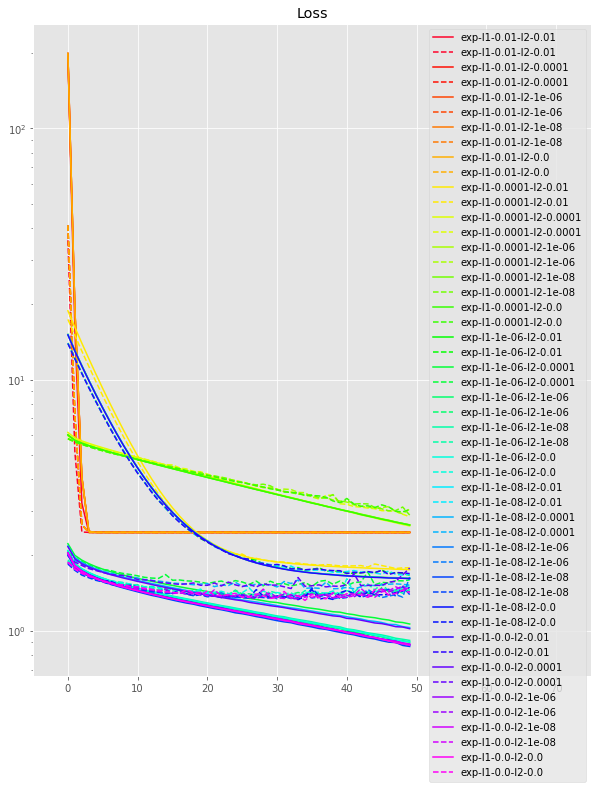

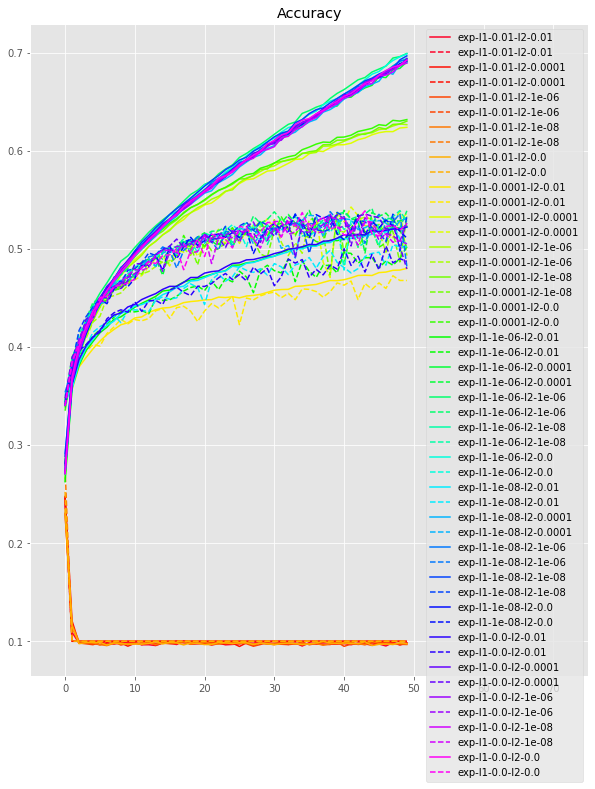

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
"""Code Here
將結果繪出
"""
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#color_bar = ["r", "g", "b", "c", "y", "m", "k", "w"]

plt.figure(figsize=(10,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.xlim((-5,75))
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(10,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.xlim((-5,75))
plt.legend()
plt.show()